### comment out the code below to install required packages

In [1]:
# code to install all the packages we need
# %pip install numpy
# %pip install pandas
# %pip install yfinance
# %pip install requests
# %pip install beautifulsoup4
# %pip install scikit-learn
# %pip install TA-lib
# %pip install joblib
# %pip install pickle-mixin
# %pip install Riskfolio-lib


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import yfinance as yf
from ibapi.client import *
from ibapi.wrapper import *
from ibapi.contract import *
from ibapi.order import *
import ibapi

import requests
import bs4 as bs
import datetime
import time
import threading
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV  
import joblib

import talib as ta
from talib import MA_Type
import pickle
import riskfolio as rp

In [3]:
init_event = threading.Event() # init event
id_event = threading.Event()
mkt_event = threading.Event()
hist_event = threading.Event()
order_event = threading.Event()
evec_event = threading.Event()
port_event = threading.Event()
value_event = threading.Event()

In [4]:
# define the App class
class App(EClient, EWrapper):
    def __init__(self, address, port, cid):
        EClient.__init__(self, self)
        # # list to store data
        self.bar_dict = {}
        self.mkt_price = []
        # create a connection with IBKR
        self.connect(address, port, cid)
        self.last_portfolio = pd.DataFrame(columns=["ticker","quantity","marketPrice","marketValue","averageCost","unrealizedPNL","realizedPNL"])
        self.value = 0
        # start client
        thread = threading.Thread(target=self.run)
        thread.start()
        init_event.set()


    def nextValidId(self, orderId: int):
        # provide a new order id for each of my requests
        super().nextValidId(orderId)
        logging.debug("setting nextValidOrderId: %d", orderId)
        self.nextValidOrderId = orderId
        print("NextValidId:", orderId)
        id_event.set()

    def tickPrice(self, reqId: int, tickType: int, price: float, attrib: ibapi.common.TickAttrib):
            print("Tick Price. Ticker Id:", reqId, "tickType:", tickType, "Price:", price)
            if tickType == 9: # if tickType is Close Price
                self.mkt_price.append([reqId, price])
                mkt_event.set()

    def historicalData(self, reqId, bar):
        if reqId not in self.bar_dict.keys():
            self.bar_dict[reqId] = []
        self.bar_dict[reqId].append(vars(bar))
        
    def historicalDataEnd(self, reqId, start, end):
        print(f"end of historicalData")
        hist_event.set()


    # implement code to monitor trade status and receive confirmation of the trade
    def openOrder(self, orderId: OrderId, contract: Contract, order: Order, orderstate: OrderState):
        # openorder callback
        print(f"openOrder. orderId:{orderId}, contract:{contract}, order:{order}")
        order_event.set()

    def orderStatus(self, orderId: OrderId, status: str, filled: float, reamining: float, avgFillPrice: float,
                    permId: int, parenId: int, lastFillPrice: float, clientId: int, whyHeld:str, mktCapPrice: float):
                    # orderstatus callback
        print(f"orderStatus. orderId: {orderId}, status: {status}, filled: {filled}, remaining:{reamining}, avgFillPrice: {avgFillPrice}, permId:{permId}, parentId:{parenId}, lastFillPrice: {lastFillPrice}, clientId: {clientId}, whyHeld: {whyHeld}, mktCapPrice:{mktCapPrice}")

    def execDetails(self, reqId: int, contract: Contract, execution: Execution):
        print(f"execDetails. reqId: {reqId}, contract: {contract}, execution: {execution}")
        evec_event.set()
    # basically a summary

    def commissionReport(self, commissionReport: CommissionReport):
        super().commissionReport(commissionReport)
        print("CommissionReport.", commissionReport)
        
    # called when query portfolio information
    def updatePortfolio(self, contract, position, marketPrice, marketValue, averageCost, unrealizedPNL, realizedPNL, accountName):
        self.last_portfolio = pd.concat([self.last_portfolio,
                                        pd.DataFrame([[contract.symbol, position, marketPrice, marketValue, averageCost, unrealizedPNL, realizedPNL]],
                                                    columns=self.last_portfolio.columns)],
                                        ignore_index=True)
        port_event.set()

    # query total value
    def accountSummary(self, reqId: int, account: str, tag: str, value: str, currency: str):
        self.value = float(value)
        print("Total value of the account: ", self.value)
    
    def accountSummaryEnd(self, reqId: int):
        print('end of account summary')
        value_event.set()

In [5]:
# Connect to the TWS API
app = App('127.0.0.1', 7497, 1000)
init_event.wait() # wait until it's connected
init_event.clear()

In [6]:
app.reqMarketDataType(1) # in case it doesn't work, change 1 to 3

NextValidId: 176


In [7]:
with open('portfolio_list.pickle', 'rb') as f:
    portfolio_list = pickle.load(f)

print(portfolio_list)

['ALB', 'ALLE', 'CFG', 'CMA', 'DPZ', 'FRC', 'LNC', 'PNC', 'SBUX', 'WDC']


# query the current portfolio


In [8]:
app.reqAccountUpdates(True, "DU6730183") #TODO: replace the DU222526 with our account ID
# port_event.wait()
# port_event.clear()

time.sleep(10)
last_portfolio = app.last_portfolio
app.reqAccountUpdates(False, "DU6730183") 

ERROR:ibapi.wrapper:ERROR -1 2100 API client has been unsubscribed from account data.


In [9]:
last_portfolio

,ticker,quantity,marketPrice,marketValue,averageCost,unrealizedPNL,realizedPNL
0,ABT,1183,108.676193,128563.94,110.579227,-2251.29,0.0
1,ARE,1140,121.277626,138256.49,124.635000,-3827.41,0.0
2,CFG,1248,30.043903,37494.79,29.035000,1259.11,0.0
3,CMA,849,41.490417,35225.36,45.880289,-3727.00,0.0
4,DG,419,221.373642,92755.56,219.115000,946.37,0.0
5,HLT,483,140.875290,68042.77,147.539141,-3218.64,0.0
6,MDT,1095,90.536003,99136.92,83.675000,7512.80,0.0
7,MTB,327,122.980759,40214.71,125.465000,-812.35,0.0
8,PNC,267,128.199463,34229.26,126.205000,532.52,0.0
9,TSCO,294,239.517029,70418.01,248.615000,-2674.80,0.0


In [10]:
app.reqAccountUpdates(False, "DU6730183")#TODO: replace the DU222526 with our account ID
app.reqAccountSummary(9001, "All", "NetLiquidation")
value_event.wait()
value_event.clear()
# time.sleep(3)
total_value = app.value
app.cancelAccountSummary(9001)

Total value of the account:  827834.49
end of account summary


In [11]:
total_value

827834.49

# implementation
* decide what to buy & sell, as well as the quantity

In [12]:

# get the market price
for i, t in enumerate(portfolio_list):
    contract = Contract()
    contract.symbol = t
    contract.secType = "STK"
    contract.currency = "USD"
    contract.exchange = "SMART"
    app.reqMktData(i, contract, "", False, False, [])
    mkt_event.wait()
    mkt_event.clear()
    app.cancelMktData(i)

mkt_df = pd.DataFrame(app.mkt_price, columns=['reqId', 'mkt_price'])
assert sum(mkt_df.isnull().any()) == 0, "didn't get all the market price"
assert len(mkt_df) == len(portfolio_list), "didn't get all the market price"


Tick Price. Ticker Id: 0 tickType: 6 Price: 188.93
Tick Price. Ticker Id: 0 tickType: 7 Price: 180.5
Tick Price. Ticker Id: 0 tickType: 9 Price: 181.2
Tick Price. Ticker Id: 0 tickType: 4 Price: 186.99
Tick Price. Ticker Id: 1 tickType: 14 Price: 108.96
Tick Price. Ticker Id: 1 tickType: 4 Price: 110.12
Tick Price. Ticker Id: 1 tickType: 6 Price: 110.92
Tick Price. Ticker Id: 1 tickType: 7 Price: 108.66
Tick Price. Ticker Id: 1 tickType: 9 Price: 107.49
Tick Price. Ticker Id: 1 tickType: 1 Price: 110.0
Tick Price. Ticker Id: 1 tickType: 2 Price: 110.15
Tick Price. Ticker Id: 2 tickType: 1 Price: 30.05
Tick Price. Ticker Id: 2 tickType: 2 Price: 30.06
Tick Price. Ticker Id: 2 tickType: 4 Price: 30.04
Tick Price. Ticker Id: 2 tickType: 6 Price: 30.1
Tick Price. Ticker Id: 2 tickType: 7 Price: 29.35
Tick Price. Ticker Id: 2 tickType: 9 Price: 29.16
Tick Price. Ticker Id: 2 tickType: 14 Price: 29.36
Tick Price. Ticker Id: 3 tickType: 6 Price: 42.43
Tick Price. Ticker Id: 3 tickType: 7 Pric

[*********************100%***********************]  10 of 10 completed


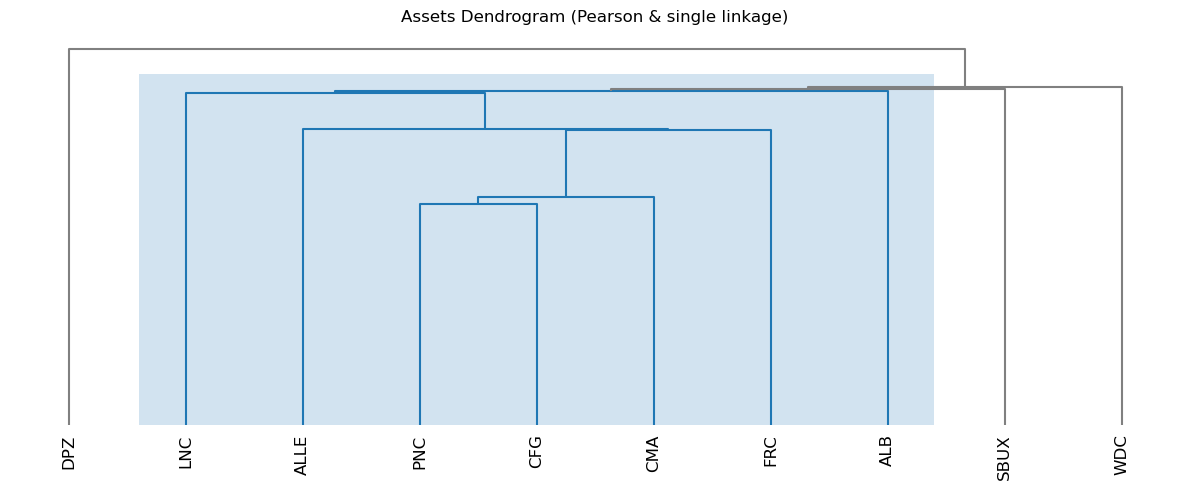

In [13]:
start = datetime.datetime(2022, 11, 1)
end = datetime.datetime.now().strftime("%Y-%m-%d") 
portfolio_list.sort()
##factors = ['MTUM', 'QUAL', 'VLUE', 'SIZE', 'USMV']
#factors.sort()
portfolioTickers = portfolio_list #+ factors
portfolioTickers.sort()
portfolioData = yf.download(portfolioTickers, start = start, end = end)
portfolioData = portfolioData.loc[:,('Adj Close', slice(None))]
portfolioData.columns = portfolioTickers
#X = portfolioData[factors].pct_change().dropna()
Y = portfolioData[portfolio_list].pct_change().dropna()
#Y = portfolioData[portfolio_list].copy()
#Y = Y.resample('M').last().pct_change().dropna()
#port = rp.Portfolio(returns=Y)
ax = rp.plot_dendrogram(returns=Y,
                        codependence='pearson',
                        linkage='single',
                        k=None,
                        max_k=5,
                        leaf_order=True,
                        ax=None)


ALB     0.084770
ALLE    0.142250
CFG     0.057594
CMA     0.054574
DPZ     0.214926
FRC     0.006818
LNC     0.046243
PNC     0.064628
SBUX    0.259037
WDC     0.069160
Name: weights, dtype: float64


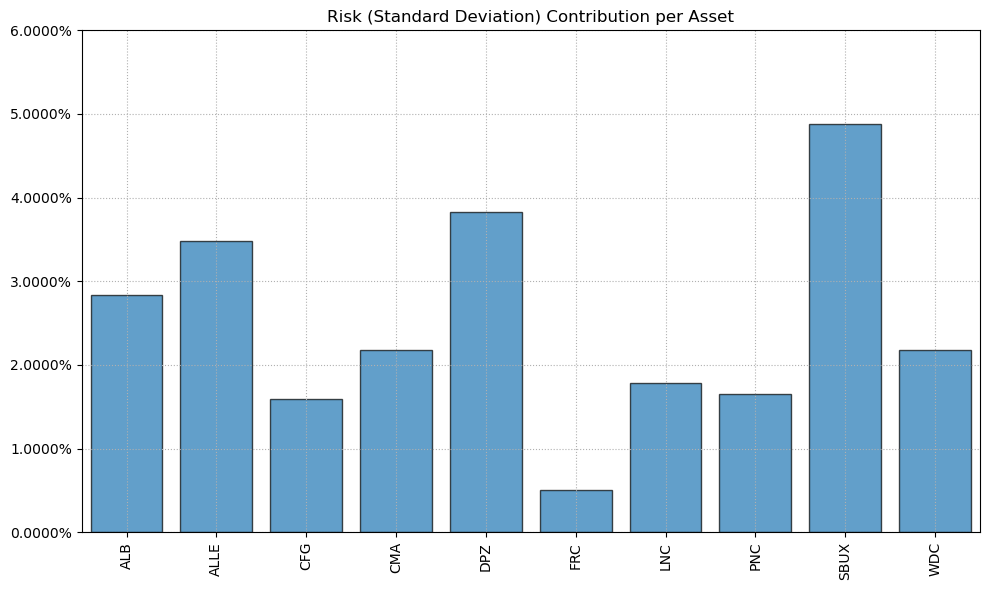

In [14]:
port = rp.HCPortfolio(returns=Y)
"""
method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.
port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
l = 0 # Risk aversion factor, only useful when obj is 'Utility'
"""
model='HRP' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
codependence = 'pearson' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'single' # Linkage method used to build clusters
max_k = 5 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = True # Consider optimal order of leafs in dendrogram
#w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      max_k=max_k,
                      leaf_order=leaf_order)

# Plotting the risk contribution per asset

mu = Y.mean()
cov = Y.cov() # Covariance matrix
returns = Y # Returns of the assets

ax = rp.plot_risk_con(w=w,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)
print(w.weights)

/home/spectre/anaconda3/envs/tensorplustorch/lib/python3.10/site-packages/riskfolio/PlotFunctions.py:569: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sizes2 = sizes2.append(item)


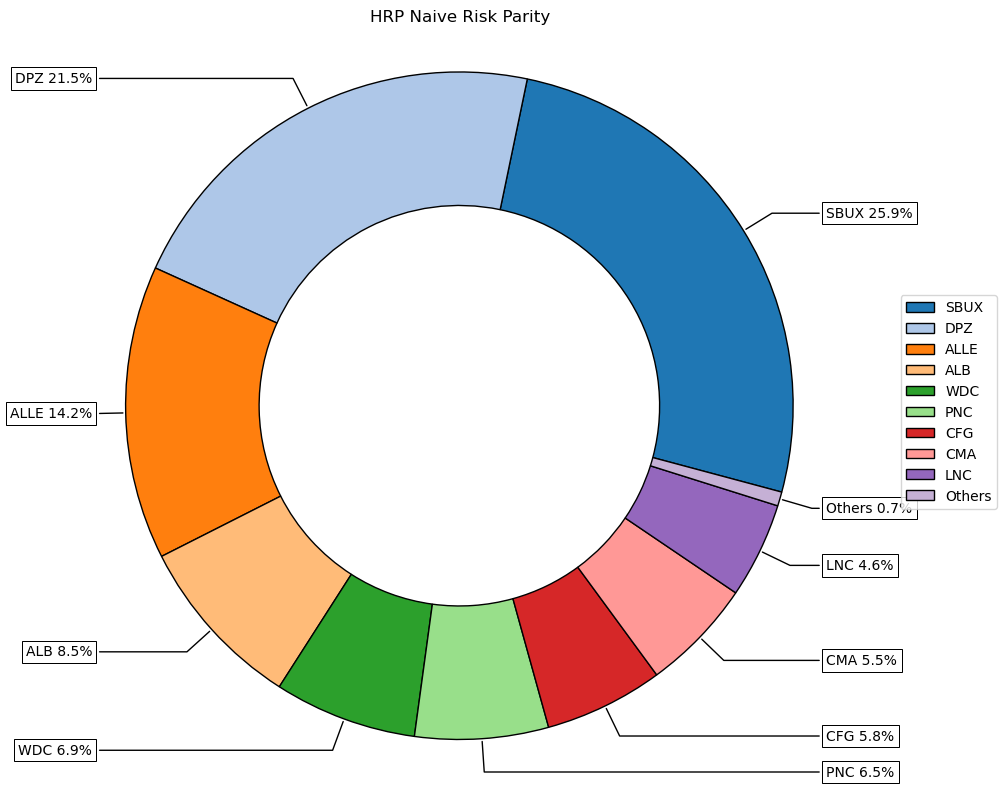

In [15]:
ax = rp.plot_pie(w=w,
                 title='HRP Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

In [16]:

target_portfolio = pd.DataFrame(columns=['tickers', 'weight', 'mkt_price'])
target_portfolio['tickers'] = portfolio_list
target_portfolio['weight'] = list(w.weights)
target_portfolio['mkt_price'] = mkt_df['mkt_price']

In [17]:
target_portfolio['quantity'] = np.floor(target_portfolio['weight'] * (total_value * 0.95) / target_portfolio['mkt_price'])

In [18]:
last_portfolio

,ticker,quantity,marketPrice,marketValue,averageCost,unrealizedPNL,realizedPNL
0,ABT,1183,108.676193,128563.94,110.579227,-2251.29,0.0
1,ARE,1140,121.277626,138256.49,124.635000,-3827.41,0.0
2,CFG,1248,30.043903,37494.79,29.035000,1259.11,0.0
3,CMA,849,41.490417,35225.36,45.880289,-3727.00,0.0
4,DG,419,221.373642,92755.56,219.115000,946.37,0.0
5,HLT,483,140.875290,68042.77,147.539141,-3218.64,0.0
6,MDT,1095,90.536003,99136.92,83.675000,7512.80,0.0
7,MTB,327,122.980759,40214.71,125.465000,-812.35,0.0
8,PNC,267,128.199463,34229.26,126.205000,532.52,0.0
9,TSCO,294,239.517029,70418.01,248.615000,-2674.80,0.0


In [19]:
target_portfolio

,tickers,weight,mkt_price,quantity
0,ALB,0.084770,181.20,367.0
1,ALLE,0.142250,107.49,1040.0
2,CFG,0.057594,29.16,1553.0
3,CMA,0.054574,40.62,1056.0
4,DPZ,0.214926,339.03,498.0
5,FRC,0.006818,5.69,942.0
6,LNC,0.046243,20.47,1776.0
7,PNC,0.064628,127.85,397.0
8,SBUX,0.259037,111.47,1827.0
9,WDC,0.069160,32.68,1664.0


# figure out the best order of our order. (To save commission fee)

* target_portfolio
> target_portfolio python pandas dataframe containing information of stocks portfolio(target portfolio) that I want to form through trading. The first column of the dataframe is stocks' tickers and the second column of the dataframe is the quantity of each stock that I want to hold. 

* last_portfolio
> last_portfolio is a dataframe containing information of last portfolio that I hold

In [20]:
# Create a list to store the stocks that need to be sold
stocks_to_sell = []
# Create a list to store the stocks that need to buy
stocks_to_buy = []

# Iterate through the target_portfolio dataframe
for index, row in target_portfolio.iterrows():
    # Check if the stock is present in the last_portfolio dataframe
    last_portfolio_stock = last_portfolio[last_portfolio['ticker'] == row['tickers']]
    if not last_portfolio_stock.empty:
        # Compare the quantities
        last_portfolio_quantity = float(last_portfolio_stock['quantity'].values[0])
        if row['quantity'] < last_portfolio_quantity:
            # Calculate the difference in quantity
            quantity_diff = last_portfolio_quantity - row['quantity'] 
            # Add the stock to the list of stocks to sell
            stocks_to_sell.append([row['tickers'], quantity_diff])

        if row['quantity'] > last_portfolio_quantity:
            # Calculate the difference in quantity
            quantity_diff = row['quantity'] - last_portfolio_quantity 
            # Add the stock to the list of stocks to buy
            stocks_to_buy.append([row['tickers'], quantity_diff])

# we also need to sell the stocks that are in last_portfolio but not in target_portfolio
# Find the difference between the two portfolios
new_tickers_to_sell = set(last_portfolio['ticker']).difference(set(target_portfolio['tickers']))

for ticker in new_tickers_to_sell:
    # Find the quantity of the stock to sell from the last_portfolio
    quantity = last_portfolio.loc[last_portfolio['ticker'] == ticker, 'quantity'].values[0]
    # append to stocks to sell
    if quantity != 0:
        stocks_to_sell.append([ticker, quantity])

# we also need to buy the stocks that are in target_protfolio but not in last_portfolio
# Find the difference between the two portfolios
new_tickers_to_buy = set(target_portfolio['tickers']).difference(set(last_portfolio['ticker']))

for ticker in new_tickers_to_buy:
    # Find the quantity of the stock to buy from the target_portfolio
    quantity = target_portfolio.loc[target_portfolio['tickers'] == ticker, 'quantity'].values[0]
    # append to stocks to buy
    if quantity != 0:
        stocks_to_buy.append([ticker, quantity])

In [21]:
stocks_to_buy

[['CFG', 305.0],
 ['CMA', 207.0],
 ['PNC', 130.0],
 ['ALB', 367.0],
 ['ALLE', 1040.0],
 ['SBUX', 1827.0],
 ['LNC', 1776.0],
 ['DPZ', 498.0],
 ['FRC', 942.0],
 ['WDC', 1664.0]]

In [22]:
stocks_to_sell

[['ARE', Decimal('1140')],
 ['ABT', Decimal('1183')],
 ['MDT', Decimal('1095')],
 ['MTB', Decimal('327')],
 ['TSCO', Decimal('294')],
 ['HLT', Decimal('483')],
 ['DG', Decimal('419')]]

# place order

In [23]:
app.reqIds(-1) # require a new id
id_event.wait()
id_event.clear()
orderid = app.nextValidOrderId
for stock in stocks_to_sell:
    # Replace the place holder values with the appropriate values
    ticker = stock[0]
    quantity = stock[1]
    contract = Contract()
    contract.symbol = ticker
    contract.secType = "STK"
    contract.exchange = "SMART"
    contract.currency = "USD"
    order = Order()
    order.action = "SELL"
    order.orderType = "MKT"
    order.totalQuantity = quantity
    order.tif = "GTC" # default is day order

    orderid += 1

    app.placeOrder(orderid, contract, order)
    order_event.wait()
    order_event.clear()

count = 0
for stock in stocks_to_buy:
    # Replace the place holder values with the appropriate values
    app.reqAccountUpdates(False, "DU6730183")#TODO: replace the DU222526 with our account ID
    app.reqAccountSummary(9001, "All", "SettledCash")
    value_event.wait()
    value_event.clear()
    cash_value = app.value
    if count >= len(stocks_to_buy)/2 and cash_value <= 0:
        break # stop buying when cash is below 0
    ticker = stock[0]
    quantity = stock[1]
    contract = Contract()
    contract.symbol = ticker
    contract.secType = "STK"
    contract.exchange = "SMART"
    contract.currency = "USD"
    order = Order()
    order.action = "BUY"
    order.orderType = "MKT"
    order.totalQuantity = quantity
    order.tif = "GTC" # default is day order

    orderid += 1
    app.placeOrder(orderid, contract, order)
    order_event.wait()
    order_event.clear()
    count +=1

NextValidId: 176
openOrder. orderId:177, contract:6607487,ARE,STK,,0,?,,SMART,,USD,ARE,ARE,False,,,,combo:, order:177,1000,592097355: MKT SELL 1140@121.39 GTC
orderStatus. orderId: 177, status: PreSubmitted, filled: 0, remaining:1140, avgFillPrice: 0.0, permId:592097355, parentId:0, lastFillPrice: 0.0, clientId: 1000, whyHeld: , mktCapPrice:0.0
execDetails. reqId: -1, contract: 6607487,ARE,STK,,0,,,CHX,,USD,ARE,ARE,False,,,,combo:, execution: ExecId: 0000e0d5.6454597c.01.01, Time: 20230427 13:29:02 US/Eastern, Account: DU6730183, Exchange: CHX, Side: SLD, Shares: 400, Price: 121.39, PermId: 592097355, ClientId: 1000, OrderId: 177, Liquidation: 0, CumQty: 400, AvgPrice: 121.39, OrderRef: , EvRule: , EvMultiplier: 0, ModelCode: , LastLiquidity: 2
openOrder. orderId:177, contract:6607487,ARE,STK,,0,?,,SMART,,USD,ARE,ARE,False,,,,combo:, order:177,1000,592097355: MKT SELL 1140@121.39 GTC
orderStatus. orderId: 177, status: PreSubmitted, filled: 400, remaining:740, avgFillPrice: 121.39, perm

In [24]:
app.disconnect()